In [9]:
def get_relevant_activations(data, markup_for_tag):
    result = []
    for i, tag in enumerate(markup_for_tag):
        if tag != 0:
            result.append(data[i])
    return np.stack(result)


def get_matches(activations, markup):
    markup = np.array(markup)
    markup_devs = markup - np.mean(markup)
    activation_devs = activations - np.mean(activations, 0, keepdims=True)
    activation_stddevs = np.std(activations, 0, ddof=1, keepdims=True)
    markup_stddev = np.std(markup, ddof=1)
    activation_dev_fractions = activation_devs / (activation_stddevs + 1e-20)
    markup_dev_fractions = markup_devs / (markup_stddev + 1e-20)
    return activation_dev_fractions * np.reshape(markup_dev_fractions, [-1, 1])


def compute_stats(data, markup_for_tag):
    markup_for_tag = np.array(markup_for_tag)
    stats = {}
    stats['markup'] = markup_for_tag
    stats['relevant_markup'] = list(filter(lambda x: x != 0, markup_for_tag))
    stats['relevant_activations'] = get_relevant_activations(data, markup_for_tag)
    stats['matches'] = get_matches(stats['relevant_activations'], stats['relevant_markup'])
    stats['correlations'] = np.mean(stats['matches'], 0)
    assert stats['correlations'].ndim == 1
    stats['match_stddevs'] = np.std(stats['matches'], 0)
    stats['mean_square_correlation'] = np.sqrt(np.mean(stats['correlations']**2))
    stats['meta'] = {
        "positive": np.count_nonzero(markup_for_tag == 1),
        "negative": np.count_nonzero(markup_for_tag == -1),
        "total": len(stats['markup']),
    }
    return stats

In [11]:
import os
import pickle
import numpy as np

os.makedirs('test', exist_ok=True)

with open("test/test.pickle", 'wb') as f:
    pickle.dump(np.array([[4]*10]*50), f)

In [12]:
! ls -l test

итого 8
-rw-rw-r-- 1 anton anton 4160 июн  7 11:29 test.pickle


In [5]:
import tensorflow as tf

def get_axis_quarters(tensor):
    last_dim = tf.shape(tensor, out_type=tf.float32)[-1]
    exponents = tf.range(0., last_dim, 1., dtype=tf.float32)
    powers = tf.math.pow(2., exponents)
    binary_format = tf.cast(tensor > 0, tf.float32)
    linear_combination = powers * binary_format
    numbers = tf.reduce_sum(linear_combination, axis=-1)
    return tf.cast(numbers, tf.int32)

tensor = tf.constant(
    [[1, -1, 1],
     [-1, -1, -1]]
)

axis_quarters = get_axis_quarters(tensor)

with tf.Session() as sess:
    print(sess.run(axis_quarters))

[5 0]


In [1]:
import pickle
import numpy as np

prefix = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS'

tmpl = os.path.join(prefix, '{}.pickle')

In [ ]:
file_name = tmpl.format('correlations')
with open(file_name, 'rb') as f:
    corr = pickle.load(f)
    
print(max(corr))
print(np.argmax(corr))

In [1]:
from collections import Counter
import numpy as np

a = np.array([1, 2, 3])

c = Counter(a)
print(c)

Counter({1: 1, 2: 1, 3: 1})


In [3]:
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

m62 = m[:, 62]
print(m62)
print(max(m62))
print(np.argmax(m62))
print(min(m62))
print(np.argmin(m62))

[ 0.08246549  0.02131961  0.08308583 ... -0.55830922  0.02906624
  0.02100856]
18.750923953380248
50567
-13.644160917601068
52351


In [4]:
print(np.std(m62))

2.387342495802599


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

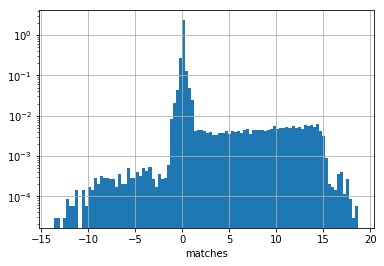

In [6]:
threshold = 0
f1 = m62[m62 > threshold]
f2 = m62[m62 <= -threshold]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('matches')

plt.show()

In [2]:
act = tmpl.format('relevant_activations')
with open(act, 'rb') as f:
    act = pickle.load(f)

In [3]:
markup = tmpl.format('relevant_markup')
with open(markup, 'rb') as f:
    markup = pickle.load(f)

In [4]:
act62 = act[:, 62]

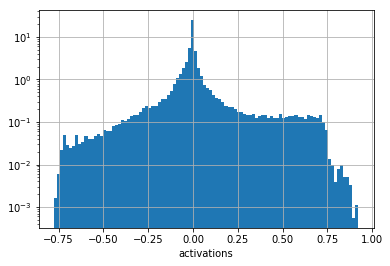

In [8]:

plt.hist(act62, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('activations')

plt.show()

In [5]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(m62, 0.001, None, 'blue')
plt.yscale('log')
plt.xlabel('matches')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/matches.png',
    dpi=900
)
plt.show()

NameError: name 'm62' is not defined

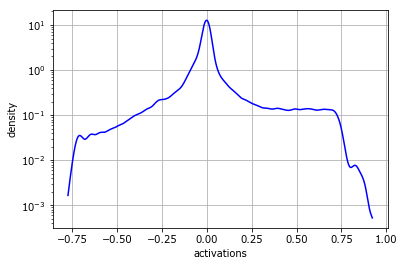

In [19]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(act62, 0.0001, None, 'blue')
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/activations.png',
    dpi=900
)
plt.show()

In [7]:
from helmo.util.plot.plot_helpers import density_plot

selected_indices = np.array(np.array(markup) + 1, dtype=bool)

In [8]:
nns_act62 = act62[selected_indices]

In [9]:
import numpy as np

print(nns_act62.shape)
print(nns_act62[:100])
min_ = np.min(act62)
max_ = np.max(act62)

(7996,)
[ 0.03987525  0.24359564  0.13936374  0.01275242  0.33905667  0.23092057
  0.49802893  0.7179312   0.6440741   0.72047305  0.68238884  0.27751622
  0.7226443   0.66829014  0.6769268   0.35996893  0.62734854  0.4216515
  0.53920376 -0.07121509  0.5742651   0.7341397   0.23616292  0.7350702
  0.13083465  0.35654765  0.5455406   0.41869763  0.5783358   0.61539644
  0.6135536   0.62634987  0.23542795  0.21027555  0.6333601   0.036227
  0.43719196  0.35494202  0.13239472  0.6450477   0.7428283   0.7066073
  0.6975089   0.28573078  0.42003262  0.20334533  0.45254168  0.40931424
  0.15804431  0.5475083   0.12762508  0.30116114  0.46461856  0.6587762
  0.34424582  0.47947675  0.7382973   0.43743163  0.48655224  0.3983338
  0.6633929   0.5986025   0.6500519   0.72113675  0.61620504  0.70613456
  0.02858962  0.5844811   0.5168905   0.2948563   0.41682157  0.40695137
  0.5016543   0.3709565   0.7006538   0.62645507 -0.00999689  0.631873
  0.37047824  0.10538723 -0.12101641  0.3286183   0.

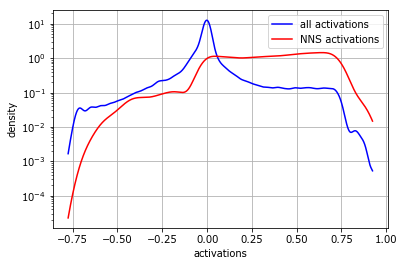

In [13]:
import os

import matplotlib.pyplot as plt

density_plot(act62, 0.0001, 'all activations', 'blue')
density_plot(nns_act62, 0.0001, 'NNS activations', 'red', [min_, max_])
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.legend(loc='best')
plt.savefig(
    os.path.join(prefix, 'plots/activations_and_nns_activations.png'),
    dpi=900
)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


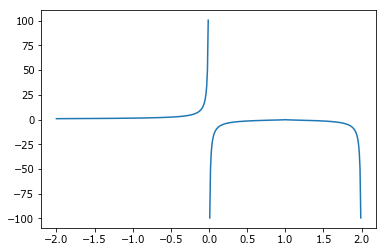

In [15]:
x = [0.01*i for i in range(-200, 200)]
y = [1 / np.log(abs(xx-1.)) for xx in x]

plt.plot(x, y)
plt.show()

In [171]:
! export PYTHONPATH="~/h-elmo:~/learning-to-learn"

In [173]:
! echo $PYTHONPATH

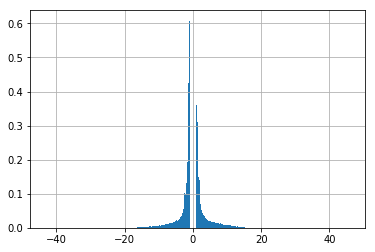

In [25]:
f1 = m[m > 1.]
f2 = m[m < -1.]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=1000, density=True)
plt.grid()
plt.show()

In [ ]:
tmpl = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level0_0/NNS/{}.pickle'
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

In [ ]:
act = tmpl.format('activations')
with open(act, 'rb') as f:
    a = pickle.load(f)
    


In [ ]:
stddevs = tmpl.format('match_stddevs')
with open(stddevs, 'rb') as f:
    std = pickle.load(f)

print(std)
print(max(std))
print(np.argmax(std))

In [1]:
import tensorflow as tf


def get_all_values_except_specified(tensor, excluded):
    with tf.name_scope('get_all_values_except_specified'):
        tensor = tf.reshape(tensor, [-1])
        excluded = tf.reshape(excluded, [-1])
        excluded_shape = tf.shape(excluded)
        tensor_expanded = tf.reshape(tensor, [-1, 1])
        multiples = tf.concat([[1], excluded_shape], 0)
        tensor_expanded = tf.tile(tensor_expanded, multiples)
        masks = tf.cast(tf.equal(tf.cast(tensor_expanded, tf.int32), tf.cast(excluded, tf.int32)), tf.int32)
        mask = tf.reduce_sum(masks, [1])
        mask = tf.cast(tf.cast(mask, dtype=tf.bool), dtype=tf.int32) - 1
        return tf.boolean_mask(tensor, mask)
    

tensor, num_dims, axes, output = (
                    [[[1, 2], [3, 4]], [[5, 6], [7, 8]]],

                    5,

                    [0, 2, 4],

                    [[[[[1, 2]], [[3, 4]]], [[[5, 6]], [[7, 8]]]]],
                )

if not tf.contrib.framework.is_tensor(tensor):
    tensor = tf.constant(tensor)
if not tf.contrib.framework.is_tensor(axes):
    axes = tf.constant(axes, dtype=tf.int32)
sh = tf.shape(tensor, out_type=tf.int32)
nd = tf.shape(sh, out_type=tf.int32)[0]
assert_axes_smaller_than_num_dims = tf.assert_less(
    axes, num_dims, message='`axes` has to be less than `num_dims`')
check_num_dims = tf.assert_greater_equal(
    num_dims, nd,
    message='`num_dims` has to be greater or equal to number of dimensions in `tensor`'
)
ass_axes_bigger_or_equal_than_num_dims = tf.assert_greater_equal(axes, -num_dims)

negative_axes_mask = tf.cast(axes < 0, tf.int32)
axes += negative_axes_mask * num_dims

ones_for_expansion = tf.ones(tf.reshape(num_dims - nd, [1]), dtype=tf.int32)
shape_for_expansion = tf.concat([sh, ones_for_expansion], 0)

tensor = tf.reshape(tensor, shape_for_expansion)

# remained_axes = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
# perm = tf.concat([axes, remained_axes], 0)
updates = tf.range(0, num_dims, 1, dtype=tf.int32)
remained_positions = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
indices = tf.concat([axes, remained_positions], 0)
indices = tf.reshape(indices, [-1, 1])
perm_shape = tf.reshape(num_dims, [1])
perm = tf.scatter_nd(indices, updates, perm_shape)

with tf.control_dependencies([check_num_dims, assert_axes_smaller_than_num_dims, ass_axes_bigger_or_equal_than_num_dims]):
    tensor = tf.transpose(tensor, perm=perm)
    

with tf.Session() as sess:
    print(sess.run(tensor))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[[[[1 2]]

   [[3 4]]]]



 [[[[5 6]]

   [[7 8]]]]]


In [1]:
import numpy as np

from helmo.util.scripts.text_neuron_correlation import compute_stats

num_unrollings = 20
num_units = 4

# a = np.random.rand(num_units, num_unrollings)

m = np.random.choice([-1, 1, 0], num_unrollings)
a = np.stack([m]*num_units, 1)
print(a)

stats = compute_stats(a, m)
print(stats)

[[-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]]
{'markup': array([-1,  1,  0, -1,  1, -1,  1, -1,  0,  0, -1, -1, -1, -1,  0,  1,  0,
        1,  0,  1]), 'relevant_markup': [-1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1], 'relevant_activations': array([[-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1]]), 'matches': array([[0.75      , 0.75      , 0.75      , 0.75      ],
       [1.33333333, 1.33333333, 1.33333333, 1.33333333],
       [0.75      , 

In [161]:
import numpy as np


def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part


def get_kth_digit(number, k, default='0'):
    """Returns k-th digit. For example, in number 123.45 1 
    is 2nd digit, 3 is zeroth and 5 is -2nd. 
    If the number does not have such a digit default is returned.
    Args:
        number: float or str convertable to float
        k: integer
    Returns:
        str"""
    if isinstance(number, str):
        number = float(number)
    int_part = get_int_part(number)
    frac_part = get_frac_part(number)
    number = int_part + frac_part
    k = len(int_part) - k - 1
    if 0 <= k < len(number):
        return number[k]
    else:
        return default
    
    
def get_first_nonzero_digit_pos(n):
    if n == 0:
        return None
    int_part = get_int_part(n)
    frac_part = get_frac_part(n)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


def get_acc_num_digits(std, acc):
    if std == 0:
        return None
    
    std_err = std * acc
    
    nz_err = get_first_nonzero_digit_pos(std_err)
    
    digit_1_pos_higher = get_kth_digit(std, nz_err+1)
    
    higher_digit_change = get_kth_digit(std + std_err, nz_err+1) != digit_1_pos_higher or \
        get_kth_digit(std - std_err, nz_err+1) != digit_1_pos_higher

    if higher_digit_change:
        nz_err += 1
    return nz_err

for std in np.linspace(0, 1, 101):
    last_digit = get_acc_num_digits(std, 0.2)
    print(std, last_digit)

0.0 None
0.01 -2
0.02 -2
0.03 -2
0.04 -2
0.05 -2
0.06 -2
0.07 -2
0.08 -2
0.09 -1
0.1 -1
0.11 -1
0.12 -1
0.13 -2
0.14 -2
0.15 -2
0.16 -2
0.17 -1
0.18 -1
0.19 -1
0.2 -1
0.21 -1
0.22 -1
0.23 -1
0.24 -1
0.25 -1
0.26 -1
0.27 -1
0.28 -1
0.29 -1
0.3 -1
0.31 -1
0.32 -1
0.33 -1
0.34 -1
0.35000000000000003 -1
0.36 -1
0.37 -1
0.38 -1
0.39 -1
0.4 -1
0.41000000000000003 -1
0.42 -1
0.43 -1
0.44 -1
0.45 -1
0.46 -1
0.47000000000000003 -1
0.48 -1
0.49 -1
0.5 -1
0.51 -1
0.52 -1
0.53 -1
0.54 -1
0.55 -1
0.56 -1
0.5700000000000001 -1
0.58 -1
0.59 -1
0.6 -1
0.61 -1
0.62 -1
0.63 -1
0.64 -1
0.65 -1
0.66 -1
0.67 -1
0.68 -1
0.6900000000000001 -1
0.7000000000000001 -1
0.71 -1
0.72 -1
0.73 -1
0.74 -1
0.75 -1
0.76 -1
0.77 -1
0.78 -1
0.79 -1
0.8 -1
0.81 -1
0.8200000000000001 -1
0.8300000000000001 -1
0.84 0
0.85 0
0.86 0
0.87 0
0.88 0
0.89 0
0.9 0
0.91 0
0.92 0
0.93 0
0.9400000000000001 0
0.9500000000000001 0
0.96 0
0.97 0
0.98 0
0.99 0
1.0 0


In [138]:
get_kth_digit(123.45678, -4)

'7'

In [132]:
def get_first_nonzero_digit_pos_for_std(std, acc):
    if std == 0:
        return None
    std_fraction = std * acc
    int_part = get_int_part(std_fraction)
    frac_part = get_frac_part(std_fraction)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


get_first_nonzero_digit_pos_for_std(0.0123456, 1000)

1

In [116]:
def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part

len(get_frac_part(2.2250738585072014e-308))

324

In [1]:
import sys

import tensorflow as tf


def get_probabilities_from_histograms(histograms, axis):
    with tf.name_scope('probabilities_from_histograms'):
        n = tf.reduce_sum(histograms, axis=axis, keepdims=True)
        probabilities = tf.cast(histograms, tf.float32) / tf.cast(n, tf.float32)
        return probabilities
    
    
def entropy_MLE_from_prob(probabilities, axis, keepdims=False):
    with tf.name_scope('entropy_MLE_from_prob'):
        log_prob = tf.log(probabilities) / tf.log(2.)
        log_prob = tf.where(
            tf.logical_or(tf.is_nan(log_prob), tf.is_inf(log_prob)),
            x=tf.zeros(tf.shape(log_prob)),
            y=log_prob
        )
        products = probabilities * log_prob
        return -tf.reduce_sum(products, axis=axis, keepdims=keepdims)


def entropy_MLE_from_hist(histograms, axis, keepdims=False):
    with tf.name_scope('entropy_MLE_from_hist'):
        probabilities = get_probabilities_from_histograms(histograms, axis)
        return entropy_MLE_from_prob(probabilities, axis, keepdims=keepdims)
    
    
def get_sample_size_and_support_from_hist(
        histograms,
        axis,
        keepdims=False,
        dtype=tf.float32
):
    with tf.name_scope('get_sample_size_and_support_from_hist'):
        n = tf.reduce_sum(histograms, axis=axis, keepdims=True)
        m = tf.count_nonzero(histograms, axis=axis, keepdims=True)
        n = tf.cast(n, dtype)
        m = tf.cast(m, dtype)
    return n, m


def entropy_MM_from_hist(histograms, axis, keepdims=False):
    with tf.name_scope('entropy_MM_from_hist'):
        n, m = get_sample_size_and_support_from_hist(
            histograms, axis, keepdims=True)
        entropy = entropy_MLE_from_hist(histograms, axis, keepdims=True) + (m - 1.) / (2. * n)
        if keepdims:
            return entropy
        return tf.squeeze(entropy, axis=axis)
        

def entropy_MM_from_prob(probabilities, n, m, axis, keepdims=False):
    with tf.name_scope('entropy_MM_from_prob'):
        n = tf.cast(n, tf.float32)
        m = tf.cast(m, tf.float32)
        entropy = entropy_MLE_from_prob(probabilities, axis, keepdims=True) + (m - 1.) / (2. * n)
        if keepdims:
            return entropy
        return tf.squeeze(entropy, axis=axis)
    
    
def sort_2_tf_values(value_1, value_2):
    with tf.name_scope('sort_2_tf_values'):
        first_value, second_value = tf.cond(
            tf.greater(value_1, value_2),
            true_fn=lambda: [value_2, value_1],
            false_fn=lambda: [value_1, value_2],
        )
        return first_value, second_value
    
    
def permute_two_axes(tensor, axis_1, axis_2):
    with tf.name_scope('permute_two_axes'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis_1 %= num_dims
        axis_2 %= num_dims
        first_axis, second_axis = sort_2_tf_values(axis_1, axis_2)
        range_ = tf.range(num_dims)
        false_value = tf.concat(
            [
                range_[:first_axis],
                tf.reshape(second_axis, [1]),
                range_[first_axis + 1:second_axis],
                tf.reshape(first_axis, [1]),
                range_[second_axis + 1:]
            ],
            0
        )
        permutation = tf.cond(
            tf.equal(axis_1, axis_2),
            true_fn=lambda: range_,
            false_fn=lambda: false_value,
        )
        return tf.transpose(tensor, perm=permutation)


class PermuteTwoAxes:
    def __init__(self, tensor, axis_1, axis_2=-1):
        self.tensor = tensor
        self._axis_1 = axis_1
        self._axis_2 = axis_2

    def __enter__(self):
        self.tensor = permute_two_axes(self.tensor, self._axis_1, self._axis_2)
        return self

    def __exit__(self, exc_type, exc_value, tb):
        self.tensor = permute_two_axes(self.tensor, self._axis_1, self._axis_2)
        
        
def shift_axis(tensor, axis, position):
    with tf.name_scope('shift_axis'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        range_ = tf.range(num_dims)
        axis %= num_dims
        position %= num_dims
        first_axis, second_axis = sort_2_tf_values(axis, position)
        moved_dims = tf.reshape(axis, [1])
        fill_dims = tf.zeros([0], dtype=tf.int32)
        one = tf.constant(1)
        zero = tf.constant(0)
        first_dims, second_dims, before_2nd, after_1st, after_2nd = tf.cond(
            tf.greater(axis, position),
            true_fn=lambda: [moved_dims, fill_dims, zero, zero, one],
            false_fn=lambda: [fill_dims, moved_dims, one, one, one],
        )
        false_value = tf.concat(
            [
                range_[:first_axis],
                first_dims,
                range_[first_axis+after_1st:second_axis+before_2nd],
                second_dims,
                range_[second_axis+after_2nd:]
            ],
            0
        )
        permutation = tf.cond(
            tf.equal(axis, position),
            true_fn=lambda: range_,
            false_fn=lambda: false_value,
        )
        return tf.transpose(tensor, perm=permutation)


class TensorToMatrix:
    def __init__(self, tensor):
        self.tensor = tensor
        self._old_shape = None

    def __enter__(self):
        self._old_shape = tf.shape(self.tensor)
        self.tensor = tf.reshape(self.tensor, tf.stack([-1, self._old_shape[-1]]))
        return self

    def __exit__(self, exc_type, exc_value, tb):
        self.tensor = tf.reshape(self.tensor, tf.concat([self._old_shape[:-1], [-1]], 0))
        
        
def get_slice_specs(shape, axis, idx, sample_size):
    with tf.name_scope('get_slice_specs'):
        shape = tf.identity(shape)
        num_dims = tf.shape(shape)[0]
        axis %= num_dims
        n = shape[axis]
        zeros = tf.zeros(tf.reshape(num_dims, [1]), dtype=tf.int32)
        start = tf.concat(
            [zeros[:axis], tf.reshape(idx, [1]), zeros[axis+1:]],
            0
        )
        size = tf.concat(
            [
                shape[:axis],
                tf.reshape(tf.minimum(sample_size, n - 1 - idx), [1]),
                shape[axis+1:]
            ],
            0
        )
        return start, size
        
        
def hist_1d_loop(values, num_bins, range_, axis, max_sample_size_per_iteration):
    with tf.name_scope('hist_1d_loop'):
        shape = tf.shape(values)
        output_shape = get_output_shape_for_hist_1d(values, axis, num_bins)
        n = shape[axis]
        i0 = tf.constant(0)
        hist = tf.zeros(output_shape, dtype=tf.int32)
        
        def body(idx, hist):
            start, size = get_slice_specs(tf.shape(values), axis, idx, max_sample_size_per_iteration)
            tensor = tf.slice(values, start, size)
            hist += hist_1d(tensor, num_bins, range_, axis)
            return idx + max_sample_size_per_iteration, hist
        
        _, hist = tf.while_loop(
            lambda x, y: tf.less(x, n),
            body,
            [i0, hist],
            shape_invariants=[tf.TensorShape([]), tf.TensorShape(None)],
            parallel_iterations=1,
        )
        return tf.reshape(hist, output_shape)


def hist_1d(values, num_bins, range_, axis):
    with tf.name_scope('hist_1d'):
        discrete = tf.histogram_fixed_width_bins(values, range_, num_bins)
        return hist_from_nonnegative_ints(discrete, axis, num_bins)


def compute_probabilities(activations, num_bins, range_, axis):
    with tf.name_scope('compute_probabilities'):
        n = tf.shape(activations)[axis]
        histograms = hist_1d(activations, num_bins, range_, axis)
        probabilities = tf.cast(histograms, tf.float32) / tf.cast(n, tf.float32)
        return probabilities


def mean_neuron_entropy(activations, axis, num_bins, range_):
    with tf.name_scope('mean_neuron_entropy'):
        histograms = hist_1d(activations, num_bins, range_, axis)
        return tf.reduce_mean(entropy_MM_from_hist(histograms, axis))
    
    
def self_cross_sum(tensor, axis):
    with tf.name_scope('self_cross_sum'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis %= num_dims
        t1 = tf.expand_dims(tensor, axis=axis)
        t2 = tf.expand_dims(tensor, axis=axis+1)
        return t1 + t2


def self_cross_sum_with_factors(tensor, axis, f1, f2):
    with tf.name_scope('self_cross_sum_with_factors'):
        num_dims = tf.shape(tf.shape(tensor))[0]
        axis %= num_dims
        t1 = tf.expand_dims(tensor, axis=axis)
        t2 = tf.expand_dims(tensor, axis=axis+1)
        return f1*t1 + f2*t2
    
    
def get_output_shape_for_hist_1d(tensor, axis, num_bins):
    with tf.name_scope('get_output_shape_for_hist_1d'):
        shape = tf.shape(tensor)
        axis %= tf.shape(shape)[0]
        return tf.concat(
            [shape[:axis], tf.reshape(num_bins, [1]), shape[axis+1:]],
            0
        )
    
    
def memory_efficient_bincount(values, num_bins):
    with tf.name_scope('memory_efficient_bincount'):
        data = tf.ones(tf.shape(values), dtype=tf.int32)
        return tf.unsorted_segment_sum(data, values, num_bins)


def hist_from_nonnegative_ints(tensor, axis, num_bins):
    output_shape = get_output_shape_for_hist_1d(tensor, axis, num_bins)
    with tf.name_scope('hist_from_nonnegative_ints'):
        with PermuteTwoAxes(tensor, axis) as permute_ctx:
            with TensorToMatrix(permute_ctx.tensor) as matrix_ctx:
                shape = tf.shape(matrix_ctx.tensor)
                n = shape[0]
                shifts = tf.reshape(num_bins * tf.range(n), [-1, 1])
                prepared_values = shifts + matrix_ctx.tensor
                nb = num_bins * n
                bc = memory_efficient_bincount(prepared_values, nb)
                backward_shape = tf.concat([shape[:1], [-1]], 0)
                matrix_ctx.tensor = tf.reshape(bc, backward_shape)
            permute_ctx.tensor = matrix_ctx.tensor
        return tf.reshape(permute_ctx.tensor, output_shape)


def cross_hist_from_tensor(tensor, num_bins, range_):
    with tf.name_scope('cross_hist_from_tensor'):
        bins = tf.histogram_fixed_width_bins(
            tensor,
            range_,
            nbins=num_bins,
        )
        bins_2d = self_cross_sum_with_factors(bins, -2, 1, num_bins)
        returned_value = hist_from_nonnegative_ints(bins_2d, -1, num_bins**2)
        return returned_value


def add_cross_hist_1_slice_independent(
    idx, 
    histograms, 
    activations, 
    num_bins,
    range_,
    max_sample_size_per_iteration
):
    with tf.name_scope('add_cross_hist_1_slice_independent'):
        msspi = max_sample_size_per_iteration
        tensor = activations[..., idx:idx+msspi]
        histograms += cross_hist_from_tensor(tensor, num_bins, range_)
        return idx+msspi, histograms


def get_init_shape_of_cross_histograms(
        activations,
        num_bins
):
    shape = tf.shape(activations)
    cross_dim = tf.reshape(shape[-2], [1])
    return tf.concat(
        [
            shape[:-2],
            cross_dim,
            cross_dim,
            tf.reshape(num_bins**2, [1])
        ],
        0
    )
            

def sum_self_cross_histograms(
        activations,
        num_bins,
        range_,
        max_sample_size_per_iteration,
):
    with tf.name_scope('sum_self_cross_histograms'):
        def add_cross_hist_1_slice(idx, hists):
            return add_cross_hist_1_slice_independent(
                idx, 
                hists, 
                activations, 
                num_bins,
                range_,
                max_sample_size_per_iteration
            )
        i0 = tf.constant(0)
        n = tf.shape(activations)[-1]
        histograms = tf.zeros(
            get_init_shape_of_cross_histograms(
                activations, num_bins),
            dtype=tf.int32
        )
        _, histograms = tf.while_loop(
            lambda x, y: x < n,
            add_cross_hist_1_slice,
            [i0, histograms],
            shape_invariants=[
                tf.TensorShape([]),
                histograms.get_shape()
            ],
            back_prop=False,
            parallel_iterations=1,
        )
        return histograms
    
    
def get_cross_histograms_permutation(
        num_dims,
        value_axis,
        cross_axis, 
):
    value_axis %= num_dims
    cross_axis %= num_dims
    dims = tf.range(num_dims+1)
    first_dims, second_dims, first_axis, second_axis = tf.cond(
        tf.greater(value_axis, cross_axis),
        true_fn=lambda: [dims[-3:-1], dims[-1:], cross_axis, value_axis],
        false_fn=lambda: [dims[-1:], dims[-3:-1], value_axis, cross_axis]
    )
    return tf.concat(
        [
            dims[:first_axis],
            first_dims,
            dims[first_axis:second_axis-1],
            second_dims,
            dims[second_axis-1:-3]
        ],
        0
    )
    

def get_self_cross_histograms(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        max_sample_size_per_iteration=None,
):
    with tf.name_scope('get_self_cross_histograms'):
        if max_sample_size_per_iteration is None:
            max_sample_size_per_iteration = int(2.5e8) // num_bins
        num_dims = tf.shape(tf.shape(activations))[0]
        value_axis %= num_dims
        cross_axis %= num_dims
        output_permutation = get_cross_histograms_permutation(
            num_dims,
            value_axis,
            cross_axis,
        )
        activations = shift_axis(activations, cross_axis, -1)
        new_value_axis = value_axis - tf.cast(value_axis > cross_axis, tf.int32)
        activations = shift_axis(activations, new_value_axis, -1)
        histograms = sum_self_cross_histograms(
            activations,
            num_bins,
            range_,
            max_sample_size_per_iteration,  
        )
        return tf.transpose(histograms, perm=output_permutation)
    
    
def get_min_nonzero(tensor):
    with tf.name_scope('get_min_nonzero'):
        tensor = tf.reshape(tensor, [-1])
        unique, _ = tf.unique(tensor)
        top2, _ = tf.math.top_k(-unique, 2)
        top1, idx = tf.math.top_k(top2, 1)
        return tf.where(tf.equal(top1[0], 0), x=-top2[idx[0]-1], y=-top1[0])

    
def squeeze_tf(tensor, axis):
    with tf.name_scope('squeeze_tf'):
        shape = tf.shape(tensor)
        num_dims = tf.shape(shape)[0]
        new_shape = tf.concat([shape[:axis], shape[axis+1:]], 0)
        return tf.reshape(tensor, new_shape)
    


def mutual_information_and_min_nonzero_count(
        activations,
        value_axis, 
        cross_axis, 
        num_bins, 
        range_, 
        keepdims=False,
        max_sample_size_per_iteration=2*10**4,
):
    with tf.name_scope('mutual_information_and_min_nonzero_count'):
        num_dims = tf.shape(tf.shape(activations))[0]
        value_axis %= num_dims
        cross_axis %= num_dims
        histograms = hist_1d_loop(activations, num_bins, range_, value_axis, 10**6)
        entropy = entropy_MM_from_hist(histograms, value_axis, keepdims=True)
        entropy_sum = self_cross_sum(entropy, cross_axis)
        cross_histograms = get_self_cross_histograms(
            activations, 
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=max_sample_size_per_iteration,
        )
        value_axis = tf.cast(value_axis > cross_axis, tf.int32) + value_axis
        joint_entropy = entropy_MM_from_hist(cross_histograms, value_axis, keepdims=True)
        mutual_info = entropy_sum - joint_entropy
        min_nonzero = get_min_nonzero(cross_histograms)
        if keepdims:
            return mutual_info, min_nonzero
        else:
            return squeeze_tf(mutual_info, value_axis), min_nonzero


def mean_mutual_information_and_min_nonzero_count(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        keepdims=False,
        max_sample_size_per_iteration=2 * 10 ** 4,
):
    with tf.name_scope('mean_mutual_information_and_min_nonzero_count'):
        num_dims = tf.shape(tf.shape(activations))[0]
        value_axis %= num_dims
        cross_axis %= num_dims
        mutual_info, min_nonzero = mutual_information_and_min_nonzero_count(
            activations,
            value_axis,
            cross_axis,
            num_bins,
            range_,
            keepdims=True,
            max_sample_size_per_iteration=max_sample_size_per_iteration,
        )
        value_axis = value_axis + tf.cast(tf.greater(value_axis, cross_axis), tf.int32)
        if not keepdims:
            mutual_info = squeeze_tf(mutual_info, value_axis)
        mutual_info_reshaped = shift_axis(mutual_info, cross_axis + 1, -1)
        mutual_info_reshaped = shift_axis(mutual_info_reshaped, cross_axis, -1)
        diag = tf.linalg.diag_part(mutual_info_reshaped)
        N = tf.reduce_prod(tf.shape(mutual_info_reshaped))
        n = tf.reduce_prod(tf.shape(diag))
        s = tf.reduce_sum(mutual_info_reshaped) - tf.reduce_sum(diag)
        return mutual_info, s / tf.cast(N - n, tf.float32), min_nonzero

In [2]:
import random
import timeit

import numpy as np
np.set_printoptions(threshold=np.nan)


def test_shift_axis():
    tensor = tf.zeros([2, 3, 4])
    t = shift_axis(tensor, 0, 2)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(t))


def test_get_output_shape_for_hist_1d():
    print('\n' + "*"*20 + '\nget_output_shape_for_hist_1d')
    tensor = tf.zeros([2, 3, 4, 5, 6, 7])
    axis = -1
    num_bins = 10
    shape = get_output_shape_for_hist_1d(tensor, axis, num_bins)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(shape))


def test_self_cross_sum_with_factors():
    print('\n' + "*"*20 + '\nself_cross_sum_with_factors')
    tensor = [[1, 2, 3], [4, 5, 6]]
    cs = self_cross_sum_with_factors(tensor, 0, 10, 1)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(cs))
    
    
def test_hist_from_nonnegative_ints():
    print('\n' + "*"*20 + '\nhist_from_nonnegative_ints')
    tensor = tf.histogram_fixed_width_bins(
        tf.random.normal([100000], dtype=tf.float32, mean=0, stddev=1),
        [-15., 15.],
        nbins=30,
    )
    tensor = tf.reshape(tensor, [10000, 10])
    hist = hist_from_nonnegative_ints(tensor, -2, 30)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(np.max(sess.run(tensor)))
        print(sess.run(hist))
    
    
def test_cross_hist_from_tensor():
    print('\n' + "*"*20 + '\ncross_hist_from_tensor')
    tensor = [[1. for _ in range(20)] + [2. for _ in range(20)], [3. for _ in range(20)] + [4. for _ in range(20)]]
    hist = cross_hist_from_tensor(tensor, 10, [0., 10.])
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(hist))


def test_add_cross_hist_1_slice_independent():
    print('\n' + "*"*20 + '\nadd_cross_hist_1_slice_independent')
    idx = tf.constant(3)
    histograms = tf.zeros([2, 2, 100], dtype=tf.int32)
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
    num_bins=10
    range_ = [0., 10.]
    max_sample_size_per_iteration = 10
    idx1, histograms1 = add_cross_hist_1_slice_independent(
        idx, 
        histograms, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    idx2, histograms2 = add_cross_hist_1_slice_independent(
        idx1, 
        histograms1, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    idx3, histograms3 = add_cross_hist_1_slice_independent(
        idx2, 
        histograms2, 
        activations, 
        num_bins,
        range_,
        max_sample_size_per_iteration
    )
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run([idx1, histograms1]))
        print(sess.run([idx2, histograms2]))
        print(sess.run([idx3, histograms3]))


def test_get_init_shape_of_cross_histograms():
    print('\n' + "*"*20 + '\nget_init_shape_of_cross_histograms')
    activations = tf.zeros([5, 6, 7, 8])
    num_bins = 10
    shape = get_init_shape_of_cross_histograms(activations, num_bins)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(shape))
    
    
def test_sum_self_cross_histograms():
    print('\n' + "*"*20 + '\nsum_self_cross_histograms')
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
    num_bins = 10
    range_ = [0., 10.]
    max_sample_size_per_iteration = 10
    histograms = sum_self_cross_histograms(
        activations,
        num_bins,
        range_,
        max_sample_size_per_iteration,
    )
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(histograms))
    
    
def test_get_cross_histograms_permutation():
    print('\n' + "*"*20 + '\nget_cross_histograms_permutation')
    perm = get_cross_histograms_permutation(10, 9, 8)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run(perm))
    
    
def test_get_self_cross_histograms():
    print('\n' + "*"*20 + '\nget_self_cross_histograms')
    activations = tf.constant(
        [
            [
                [1. for _ in range(20)] + [2. for _ in range(20)] + \
                    [1. for _ in range(20)],
                [3. for _ in range(20)] + [4. for _ in range(20)] + \
                    [3. for _ in range(10)] + [4. for _ in range(10)]
            ]
        ]
    )
#     activations = tf.transpose(
#         activations,
#         perm=[2, 1, 0]
#     )
#     value_axis = 0
#     cross_axis = 1
    value_axis = -1
    cross_axis = -2
    num_bins = 5
    range_ = [0., 5.]
    max_sample_size_per_iteration = 10
    print(activations.get_shape().as_list())
    histograms = get_self_cross_histograms(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        max_sample_size_per_iteration,
    )
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        h = sess.run(histograms)[0]
        print(h.shape)
        print(h)
    
    
def test_get_min_nonzero():
    print('\n' + "*"*20 + '\ntest_get_min_nonzero')
    tensor = tf.concat([tf.zeros([2, 3, 4]), tf.ones([2, 3, 4]), 2*tf.ones([2, 3, 4]), 3*tf.ones([2, 3, 4])], 0)
    nz = get_min_nonzero(tensor)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        print(sess.run([nz]))

        
def test_mutual_information_and_min_nonzero_count():
    print('\n' + "*"*20 + '\ntest_mutual_information_and_min_nonzero_count')
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        real_activatons = tf.random_normal([10, 16 * 10**6])
        activations = real_activatons
        value_axis = -1
        cross_axis = -2
        num_bins = 100
        range_ = [-2., 2.]
        mutual_info, min_num_events = mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=2 * 10**4,
        )
        hists = hist_1d_loop(activations, num_bins, [-2., 2.], -1, 10**6)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        entropy, mutual_info, min_num_events = sess.run(
            [entropy, mutual_info, min_num_events],
            options=run_options,
        )
        print('entropy:\n', entropy)
        print('\nmutual_info:\n', mutual_info)
        print('\nmin_num_events:\n', min_num_events)
        
        
def test_get_slice_specs():
    print('\n' + "*"*20 + '\ntest_get_slice_specs')
    shape = [3, 4, 5, 6]
    idx = 2
    axis = -1
    sample_size = 10
    start, size = get_slice_specs(shape, axis, idx, sample_size)
    with tf.Session() as sess:
        print(sess.run([start, size]))
        

def test_hist_1d_loop():
    print('\n' + "*"*20 + '\ntest_hist_1d_loop')
    values = tf.random_normal([10, 1000, 3])
    num_bins = 20
    range_ = [-3., 3.]
    axis = 1
    max_sample_size_per_iteration = 10
    hist = hist_1d_loop(values, num_bins, range_, axis, max_sample_size_per_iteration)
    with tf.Session() as sess:
        print(sess.run(hist))


def test_mean_mutual_information_and_min_nonzero_count():
    print('\n' + "*"*20 + '\ntest_mean_mutual_information_and_min_nonzero_count')
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        real_activatons = tf.random_normal([10, 16 * 10**5])
        activations = real_activatons
        value_axis = -1
        cross_axis = -2
        num_bins = 100
        range_ = [-2., 2.]
        mutual_info, mean_mutual_info, min_num_events = mean_mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=2 * 10**4,
        )
        hists = hist_1d_loop(activations, num_bins, range_, value_axis, 10**6)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        entropy, mutual_info, mean_mutual_info, min_num_events = sess.run(
            [entropy, mutual_info, mean_mutual_info, min_num_events],
            options=run_options,
        )
        print('entropy:\n', entropy)
        print('\nmutual_info:\n', mutual_info)
        print('\nmean_mutual_info:\n', mean_mutual_info)
        print('\nmin_num_events:\n', min_num_events)



test_shift_axis()
test_get_output_shape_for_hist_1d()
test_self_cross_sum_with_factors()
test_hist_from_nonnegative_ints()
test_cross_hist_from_tensor()
test_add_cross_hist_1_slice_independent()
test_get_init_shape_of_cross_histograms()
test_sum_self_cross_histograms()
test_get_cross_histograms_permutation()
test_get_self_cross_histograms()
test_get_min_nonzero()
test_mean_mutual_information_and_min_nonzero_count()

t = timeit.timeit(
    stmt="test_mutual_information_and_min_nonzero_count()",
    globals=dict(
        test_mutual_information_and_min_nonzero_count= \
            test_mutual_information_and_min_nonzero_count
    ),
    number=1,
)
print(t)

test_get_slice_specs()
test_hist_1d_loop()

Instructions for updating:
Colocations handled automatically by placer.
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]

********************
get_output_shape_for_hist_1d
[ 2  3  4  5  6 10]

********************
self_cross_sum_with_factors
[[[11 22 33]
  [41 52 63]]

 [[14 25 36]
  [44 55 66]]]

********************
hist_from_nonnegative_ints
19
[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    2    1    0    1    0    0  

[[[[ 0  0  0  0  0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0
    20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0]
   [ 0  0  0  0  0  0  0  0  0  0  0  0  0 30 10  0  0  0  0  0  0  0
     0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0]]

  [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0 10 20  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     0  0  0  0  0  0  0  0  0  0  0  0]
   [ 0  0  0  0  0  0  0  0  0  0  

In [3]:
def sample_from_distribution(distr):
    n = len(distr)
    u = np.random.uniform()
    start = 0
    cumulative = []
    for p in distr:
        start += p
        cumulative.append(start)
    i = 0
    while True:
        if i >= n:
            raise ValueError(
                "random variable `u` and has not larger than 1.0"
                " and sum of probabilities in distribution has to be equal to 1.0"
            )
        if cumulative[i] > u:
            return i
        i += 1
        
        
def sample_from_distribution_continuous(distr, borders):
    n = len(distr)
    u = np.random.uniform()
    start = 0
    cumulative = []
    for p in distr:
        start += p
        cumulative.append(start)
    i = 0
    while True:
        if i >= n:
            raise ValueError(
                "random variable `u` and has not larger than 1.0"
                " and sum of probabilities in distribution has to be equal to 1.0"
            )
        if cumulative[i] > u:
            return np.random.uniform(borders[i][0], borders[i][1])
        i += 1


def test_sample_from_distribution():
    distr = [.25, .25, .25, .25, .0]
    l = [sample_from_distribution(distr) for _ in range(100)]
    print(l)
    
    
def test_sample_from_distribution_continuous():
    distr = [.0, .25, .25, .25, .25]
    borders = [[float(i), float(i+1)] for i in range(5)]
    l = [sample_from_distribution_continuous(distr, borders) for _ in range(100)]
    print(l)
    
    
test_sample_from_distribution()
test_sample_from_distribution_continuous()

[3, 1, 0, 1, 1, 0, 2, 3, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 3, 2, 0, 2, 3, 0, 3, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 3, 2, 3, 3, 0, 3, 3, 2, 2, 2, 0, 1, 2, 1, 0, 3, 0, 1, 3, 3, 3, 3, 1, 2, 3, 2, 1, 0, 1, 2, 2, 0, 0, 1, 3, 2, 0, 3, 3, 0, 3, 1, 0, 2, 1, 3, 1, 2, 1, 3]
[3.30732052702613, 2.704484321925528, 1.1356599924090203, 4.960280783923953, 2.328815254189307, 3.042010708546553, 1.0874640825724153, 1.2471648896813257, 3.9991356343362647, 1.312624625567014, 2.0167593138575066, 1.0967421309369045, 1.4573367418188918, 3.5688291843674307, 3.5540065848419493, 1.6102653253746189, 3.5703106424130877, 3.560354627845804, 2.1141412582769825, 2.153727636254102, 2.198045370079959, 4.397287464329246, 3.2415730754342227, 2.7918545368810532, 1.861353516488777, 4.704413859583499, 2.2799691618100035, 1.1382637738031607, 1.182612751807552, 3.7394622452320494, 3.671164103430943, 1.4635704817548774, 3.1014481800254514, 2.4097307615425816, 4.599280675306451, 3.781698692097

In [17]:
def test_mean_mutual_information_and_min_nonzero_count_2():
    print('\n' + "*"*20 + '\ntest_mean_mutual_information_and_min_nonzero_count')
    distr = [.0, .25, .25, .25, .25]
    borders = [[float(i), float(i+1)] for i in range(5)]
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        activations = tf.placeholder(tf.float32)
        value_axis = -2
        cross_axis = -1
        num_bins = 5
        range_ = [-0., 5.]
        mutual_info, mean_mutual_info, min_num_events = mean_mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=2 * 10**4,
        )
        hists = hist_1d_loop(activations, num_bins, range_, value_axis, 10**6)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        for i in [50, 100, 200, 400, 1000, 2000, 5000, 10000]:
            real_activations = np.array(
                [
                    [sample_from_distribution_continuous(distr, borders) for _ in range(i)] 
                    for _ in range(4)
                ]
            ).transpose()
            entropy_r, mutual_info_r, mean_mutual_info_r, min_num_events_r = sess.run(
                [entropy, mutual_info, mean_mutual_info, min_num_events],
                options=run_options,
                feed_dict={activations: real_activations}
            )
            print('\n' + '#'*20)
            print("number of points:", i)
            print('entropy:\n', entropy_r)
            print('\nmutual_info:\n', mutual_info_r)
            print('\nmean_mutual_info:\n', mean_mutual_info_r)
            print('\nmin_num_events:\n', min_num_events_r)


def test_mean_mutual_information_and_min_nonzero_count_3():
    print('\n' + "*"*20 + '\ntest_mean_mutual_information_and_min_nonzero_count')
    distr = [.0, .25, .25, .25, .25]
    borders = [[float(i), float(i+1)] for i in range(5)]
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        activations = tf.placeholder(tf.float32)
        value_axis = -2
        cross_axis = -1
        num_bins = 5
        range_ = [-0., 5.]
        mutual_info, mean_mutual_info, min_num_events = mean_mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=2 * 10**4,
        )
        hists = hist_1d_loop(activations, num_bins, range_, value_axis, 10**6)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        for i in [50, 100, 200, 400, 1000, 2000, 5000, 10000]:
            real_activations = np.array(
                [
                    [sample_from_distribution_continuous(distr, borders) for _ in range(i)] 
                    for _ in range(2)
                ] + [[sample_from_distribution_continuous(distr, borders) for _ in range(i)]]*2
            ).transpose()
            entropy_r, mutual_info_r, mean_mutual_info_r, min_num_events_r = sess.run(
                [entropy, mutual_info, mean_mutual_info, min_num_events],
                options=run_options,
                feed_dict={activations: real_activations}
            )
            print('\n' + '#'*20)
            print("number of points:", i)
            print('entropy:\n', entropy_r)
            print('\nmutual_info:\n', mutual_info_r)
            print('\nmean_mutual_info:\n', mean_mutual_info_r)
            print('\nmin_num_events:\n', min_num_events_r)
            
            
def test_mean_mutual_information_and_min_nonzero_count_4():
    print('\n' + "*"*20 + '\ntest_mean_mutual_information_and_min_nonzero_count')
    distr = [.0, .25, .25, .25, .25]
    borders = [[float(i), float(i+1)] for i in range(5)]
    with tf.device('/gpu:0'):
#         rand_vec = tf.random_normal([1, 100000000])
#         rand_vec_2 = tf.random_normal([1, 100000000])
#         max_mutual_info_activations = tf.concat([rand_vec, -rand_vec], 0)
#         min_mutual_info_activations = tf.concat([rand_vec, rand_vec_2], 0)
        activations = tf.placeholder(tf.float32)
        value_axis = -2
        cross_axis = -1
        num_bins = 5
        range_ = [-0., 5.]
        mutual_info, mean_mutual_info, min_num_events = mean_mutual_information_and_min_nonzero_count(
            activations,
            value_axis, 
            cross_axis, 
            num_bins, 
            range_,
            max_sample_size_per_iteration=2 * 10**4,
        )
        hists = hist_1d_loop(activations, num_bins, range_, value_axis, 10**6)
        entropy = entropy_MM_from_hist(hists, value_axis)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    with tf.Session(config=config) as sess:
        for i in [50, 100, 200, 400, 1000, 2000, 5000, 10000]:
            real_activations = 0.5 * np.array(
                [
                    [sample_from_distribution_continuous(distr, borders) for _ in range(i)] 
                    for _ in range(4)
                ] + np.array([[sample_from_distribution_continuous(distr, borders) for _ in range(i)]]*4)
            ).transpose()
            entropy_r, mutual_info_r, mean_mutual_info_r, min_num_events_r = sess.run(
                [entropy, mutual_info, mean_mutual_info, min_num_events],
                options=run_options,
                feed_dict={activations: real_activations}
            )
            print('\n' + '#'*20)
            print("number of points:", i)
            print('entropy:\n', entropy_r)
            print('\nmutual_info:\n', mutual_info_r)
            print('\nmean_mutual_info:\n', mean_mutual_info_r)
            print('\nmin_num_events:\n', min_num_events_r)


test_mean_mutual_information_and_min_nonzero_count_4()


********************
test_mean_mutual_information_and_min_nonzero_count

####################
number of points: 50
entropy:
 [1.8101091 1.8832393 1.8098161 1.8285853]

mutual_info:
 [[[1.8163064  0.2481358  0.17387557 0.24109554]
  [0.24813557 1.8981521  0.30713058 0.40756893]
  [0.17387557 0.30713034 1.8105798  0.23249245]
  [0.24109554 0.40756893 0.23249221 1.8424051 ]]]

mean_mutual_info:
 0.26838312

min_num_events:
 1

####################
number of points: 100
entropy:
 [1.8981922 1.8834307 1.7335024 1.770347 ]

mutual_info:
 [[[1.9014682  0.27717113 0.17181087 0.25773835]
  [0.27717113 1.8877968  0.2035265  0.23029709]
  [0.17181087 0.20352674 1.7220167  0.21127868]
  [0.25773835 0.23029709 0.21127868 1.755602  ]]]

mean_mutual_info:
 0.22530381

min_num_events:
 1

####################
number of points: 200
entropy:
 [1.7037476 1.8134648 1.8772413 1.7626739]

mutual_info:
 [[[1.6968374  0.1178689  0.1412096  0.09154773]
  [0.1178689  1.8162493  0.1356051  0.11317515]
  [0.1412

In [3]:


def test_PermuteTwoAxes():
    print('\n' + "*"*20 + '\nPermuteTwoAxes')
#     a = tf.reshape(tf.range(12), [3, 4])
    a = tf.ones([2, 3, 4, 5])

    with PermuteTwoAxes(a, -2, axis_2=1) as ctx:
        t = ctx.tensor
        ctx.tensor = tf.reduce_sum(t, axis=-1, keepdims=True)

    t2 = ctx.tensor

    with tf.Session() as sess:
        # print(sess.run(ctx.print))
        print(sess.run([a, t, t2]))
        

def test_TensorToMatrix():
    print('\n' + "*"*20 + '\nTensorToMatrix')
    a = tf.reshape(tf.range(12), [3, 4])
    with TensorToMatrix(a) as ctx:
        t = ctx.tensor
        ctx.tensor = tf.reduce_sum(t, axis=-1, keepdims=True)

    t2 = ctx.tensor
    with tf.Session() as sess:
        # print(sess.run(ctx.print))
        print(sess.run([a, t, t2]))
        
        
def test_hist_1d():
    print('\n' + "*"*20 + '\nhist_1d')
    a = tf.truncated_normal([5, 1000, 2], mean=1, stddev=1)
    num_bins = 10
    range_ = [-4., 4.]
    axis = -2
    histograms = hist_1d(a, num_bins, range_, axis)
    with tf.Session() as sess:
        print(sess.run([histograms]))
        
        
def test_compute_probabilities():
    print('\n' + "*"*20 + '\ncompute_probabilities')
    a = tf.truncated_normal([5, 1000, 2], mean=1, stddev=1)
    num_bins = 10
    range_ = [-4., 4.]
    axis = -2
    probabilities = compute_probabilities(a, num_bins, range_, axis)
    with tf.Session() as sess:
        print(sess.run([probabilities]))
        
        
def test_entropy_MM_from_prob():
    print('\n' + "*"*20 + '\nentropy_MM_from_prob')
    axis = -2
    probabilities = tf.constant(
        [[[0.3], [0.3], [0.3]],
         [[.5], [.5], [0.]],
         [[.1], [.1], [.8]]]
    )
    n = 100
    shape = tf.shape(probabilities)
    m = [[[3]], [[2]], [[3]]]
    entropy = entropy_MM_from_prob(probabilities, n, m, axis)
    with tf.Session() as sess:
        print(sess.run([entropy]))
        
        
def test_entropy_MLE_from_prob():
    print('\n' + "*"*20 + '\nentropy_MLE_from_prob')
    axis = -2
    probabilities = tf.constant(
        [[[0.3], [0.3], [0.3]],
         [[1.], [0.], [0.]],
         [[.1], [.1], [.8]]]
    )
    entropy = entropy_MLE_from_prob(probabilities, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_entropy_MLE_from_hist():
    print('\n' + "*"*20 + '\nentropy_MLE_from_hist')
    axis = 1
    hist = tf.constant(
        [[[1], [1], [1]],
         [[2], [2], [2]],
         [[1], [2], [3]],
         [[10], [10000], [10]],
         [[0], [0], [1]]]
    )
    entropy = entropy_MLE_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_entropy_MM_from_hist():
    print('\n' + "*"*20 + '\nentropy_MM_from_hist')
    axis = -2
    hist = tf.constant(
        [[[1], [1], [1]],
         [[2], [2], [2]],
         [[1], [2], [3]],
         [[10], [10000], [10]],
         [[0], [0], [1]]]
    )
    entropy = entropy_MM_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
        
        
def test_mean_neuron_entropy():
    print('\n' + "*"*20 + '\nmean_neuron_entropy')
    a = tf.truncated_normal([10, 1000])
    axis = 1
    mean_entropy = mean_neuron_entropy(a, axis, 100, [-3., 3.])
    with tf.Session() as sess:
        res = sess.run(mean_entropy)
        print(res)


def test2_entropy_MM_from_hist():
    print('\n' + "*"*20 + '\nentropy_MM_from_hist')
    axis = -1
    a = tf.truncated_normal([10, 1000])
    hist = hist_1d(a, 100, [-1., 1.], axis)
    entropy = entropy_MM_from_hist(hist, axis)
    with tf.Session() as sess:
        res = sess.run(entropy)
        print(res)
    

test_PermuteTwoAxes()
test_TensorToMatrix()
test_hist_1d()
test_compute_probabilities()
test_entropy_MLE_from_prob()
test_entropy_MM_from_prob()
test_entropy_MLE_from_hist()
test_entropy_MM_from_hist()
test_mean_neuron_entropy()
test2_entropy_MM_from_hist()


********************
PermuteTwoAxes
[array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]]], dtype=float32), array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]

In [25]:
import numpy as np


def hist_1d_loop_numpy(tensor, num_bins, range_, axis, sample_size):
    ndim = tensor.ndim
    axis %= ndim
    shape = tensor.shape
    idx = 0
    hist = 0
    while idx < shape[axis]:
        sl = [slice(None)]*axis + \
            [slice(idx, idx+sample_size)] + \
            [slice(None)]*(ndim-2-axis)
        sl = tuple(sl)
        t = tensor[sl]
        hist += hist_1d_numpy(t, num_bins, range_, axis)
        idx += sample_size
    return hist


def adjust_histogram_range_for_numpy(range_, num_bins):
    range_ = list(range_)
    h = (range_[1] - range_[0]) / num_bins
    range_[0] += h
    range_[1] -= h
    return range_


def hist_1d_numpy(tensor, num_bins, range_, axis):
    range_ = adjust_histogram_range_for_numpy(range_, num_bins)
    bins = np.histogram_bin_edges(tensor, num_bins-2, range_)
    tensor = np.digitize(tensor, bins)
    tensor = hist_from_nonnegative_ints_numpy(
        tensor,
        axis,
        num_bins
    )
    return tensor


def shift_axis_numpy(
        tensor,
        axis,
        pos,
):
    shape = tensor.shape
    ndim = tensor.ndim
    axis %= ndim
    pos %= ndim
    dims = list(range(ndim))
    if axis == pos:
        return tensor
    if pos > axis:
        perm = dims[:axis] + dims[axis+1:pos+1] + [axis] + dims[pos+1:]
    else:
        perm = dims[:pos] + [axis] + dims[pos:axis] + dims[axis+1:]
    return tensor.transpose(*perm)


def hist_from_nonnegative_ints_numpy(
        tensor,
        axis,
        num_bins
):
    tensor = shift_axis_numpy(tensor, axis, -1)
    shape = tensor.shape
    tensor = tensor.reshape([-1, shape[-1]])
    n = tensor.shape[0]
    shifts = (np.arange(n) * num_bins).reshape([-1, 1])
    tensor += shifts
    tensor = tensor.reshape([-1])
    tensor = np.bincount(tensor, minlength=n*num_bins)
    tensor = tensor.reshape(list(shape[:-1]) + [-1])
    return shift_axis_numpy(tensor, -1, axis)


def self_cross_sum_numpy(
        tensor,
        axis,
):
    axis %= tensor.ndim
    tensor_2 = np.expand_dims(tensor, axis=axis+1)
    tensor = np.expand_dims(tensor, axis=axis)
    return tensor + tensor_2


def self_cross_sum_numpy_with_factors(
        tensor,
        axis,
        f1,
        f2,
):
    axis %= tensor.ndim
    tensor_2 = np.expand_dims(tensor, axis=axis+1)
    tensor = np.expand_dims(tensor, axis=axis)
    mul1 = f1 * tensor
    mul2 = f2 * tensor_2
    s = mul1 + mul2
    return s


def self_cross_hist(
        tensor,
        value_axis,
        cross_axis,
        num_bins,
        range_,
):
    ndim = tensor.ndim
    value_axis %= ndim
    cross_axis %= ndim
    range_ = adjust_histogram_range_for_numpy(range_, num_bins)
    bins = np.histogram_bin_edges(tensor, num_bins-2, range_)
    tensor = np.digitize(tensor, bins)
    tensor = self_cross_sum_numpy_with_factors(tensor, cross_axis, 1, num_bins)
    value_axis += int(value_axis > cross_axis)
    hist = hist_from_nonnegative_ints_numpy(tensor, value_axis, num_bins**2)
    return hist


def get_self_cross_histograms_numpy(
        activations,
        value_axis,
        cross_axis,
        num_bins,
        range_,
        max_sample_size_per_iteration=10**3,
):
    ndim = activations.ndim
    value_axis %= ndim
    cross_axis %= ndim
    shape = activations.shape
    idx = 0
    hist = 0
    while idx < shape[value_axis]:
        sl = [slice(None)]*value_axis + \
            [slice(idx, idx+max_sample_size_per_iteration)] + \
            [slice(None)]*(ndim-2-value_axis)
        sl = tuple(sl)
        tensor = activations[sl]
        hist += self_cross_hist(
            tensor,
            value_axis,
            cross_axis,
            num_bins,
            range_,
        )
        idx += max_sample_size_per_iteration
    return hist


def entropy_MLE_from_hist_numpy(hist, axis, keepdims=False):
    n = np.sum(hist, axis=axis, keepdims=True)
    hist = hist / n
    log_prob = np.log2(hist)
    hist *= log_prob
    hist = np.nan_to_num(hist)
    return -np.sum(hist, axis=axis, keepdims=keepdims)


def entropy_MM_from_hist_numpy(hist, axis, keepdims=False):
    entropy = entropy_MLE_from_hist_numpy(hist, axis, keepdims=True)
    m = np.count_nonzero(hist, axis=axis)
    m = np.expand_dims(m, axis=axis)
    n = np.sum(hist, axis=axis, keepdims=True)
    entropy = entropy + (m - 1) / (2*n)
    if keepdims:
        return entropy
    return np.squeeze(entropy + (m - 1) / (2*n), axis=axis)


def mutual_information_and_min_nonzero_count_numpy(
        activations,
        value_axis, 
        cross_axis, 
        num_bins, 
        range_, 
        keepdims=False,
        sample_size_1d=5*10**5,
        sample_size_2d=2*10**5
):
    hist = hist_1d_loop_numpy(activations, num_bins, range_, value_axis, sample_size_1d)
    entropy = entropy_MM_from_hist_numpy(hist, value_axis, keepdims=True)
    entropy_sum = self_cross_sum_numpy(entropy, cross_axis)
    cross_hist = get_self_cross_histograms_numpy(
        activations,
        value_axis, 
        cross_axis, 
        num_bins, 
        range_, 
        sample_size_2d
    )
    value_axis += int(value_axis > cross_axis)
    joint_entropy = entropy_MM_from_hist_numpy(cross_hist, value_axis, keepdims=True)
    entropy = entropy_sum - joint_entropy
    m = np.count_nonzero(cross_hist, axis=value_axis)
    min_nonzero = np.min(cross_hist)
    if keepdims:
        return entropy, min_nonzero
    return np.squeeze(entropy, axis=value_axis), min_nonzero

In [26]:
import timeit

import numpy as np


def test_shift_axis_numpy():
    a = np.zeros((3, 10, 2))
    a = shift_axis_numpy(a, 1, 2)
    print(a)


def test_hist_from_nonnegative_ints_numpy():
    a = np.random.randint(0, 10, size=(3, 10, 2))
    hist = hist_from_nonnegative_ints_numpy(a, 1, 10)
    print(hist)
    

def test_hist_1d_numpy():
    a = np.random.normal(size=[3, 10000, 2])
    hist = hist_1d_numpy(a, 30, [-3., 3.], 1)
    print(hist)
    
    
def test_self_cross_sum_numpy():
    a = np.tile(np.arange(4).reshape([1, -1]), (3, 1))
    a = self_cross_sum_numpy(a, 0)
    print(a)


def test_self_cross_sum_numpy_with_factors():
    a = np.arange(4)
    a = self_cross_sum_numpy_with_factors(a, 0, 10, 1)
    print(a)


def test_self_cross_hist():
    a = np.random.normal(size=[10**4, 4])
    hist = self_cross_hist(a, 0, 1, 10, [-3., 3.])
    print(hist)


def test_get_self_cross_histograms_numpy():
    a = np.random.normal(size=[4, 10**4])
    params = (a, 1, 0, 10, [-3., 3.])
    hist = get_self_cross_histograms_numpy(*params, 100)
    hist_simple = self_cross_hist(*params)
    print(np.all(hist == hist_simple))
    print(hist)


def test_entropy_MLE_from_hist_numpy():
    hist = np.random.randint(0, 100, size=[10000, 4])
    entropy = entropy_MLE_from_hist_numpy(hist, 0, keepdims=True)
    print(entropy)


def test_entropy_MM_from_hist_numpy():
    hist = np.random.randint(0, 100, size=[10000, 4])
    entropy = entropy_MM_from_hist_numpy(hist, 0, keepdims=True)
    print(entropy)


def test_mutual_information_and_min_nonzero_count_numpy():
    activations = np.random.normal(size=[10, 16 * 10**5])
    mi, mnz = mutual_information_and_min_nonzero_count_numpy(
        activations,
        -1, 0,
        100,
        [-2., 2.],
    )
    print(mnz)
    print(mi)


def test_hist_1d_loop_numpy():
    a = np.random.normal(size=[3, 10000, 2])
    hist = hist_1d_loop_numpy(a, 100, [-2., 2.], 1, 100)
    print(hist)


# test_shift_axis_numpy()
# test_hist_from_nonnegative_ints_numpy()
# test_hist_1d_numpy()
# test_self_cross_sum_numpy()
# test_self_cross_sum_numpy_with_factors()
# test_get_self_cross_histograms_numpy()
# test_entropy_MLE_from_hist_numpy()
# test_entropy_MM_from_hist_numpy()

t = timeit.timeit(
    stmt="test_mutual_information_and_min_nonzero_count_numpy()",
    globals=dict(
        test_mutual_information_and_min_nonzero_count_numpy=test_mutual_information_and_min_nonzero_count_numpy
    ),
    number=1
)
print(t)

# test_hist_1d_loop_numpy()

[-1.96 -1.92 -1.88 -1.84 -1.8  -1.76 -1.72 -1.68 -1.64 -1.6  -1.56 -1.52
 -1.48 -1.44 -1.4  -1.36 -1.32 -1.28 -1.24 -1.2  -1.16 -1.12 -1.08 -1.04
 -1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6  -0.56
 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12 -0.08
 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4
  0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88
  0.92  0.96  1.    1.04  1.08  1.12  1.16  1.2   1.24  1.28  1.32  1.36
  1.4   1.44  1.48  1.52  1.56  1.6   1.64  1.68  1.72  1.76  1.8   1.84
  1.88  1.92  1.96]
[-1.96 -1.92 -1.88 -1.84 -1.8  -1.76 -1.72 -1.68 -1.64 -1.6  -1.56 -1.52
 -1.48 -1.44 -1.4  -1.36 -1.32 -1.28 -1.24 -1.2  -1.16 -1.12 -1.08 -1.04
 -1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6  -0.56
 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12 -0.08
 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4
  0.44  0.48  0.52  0.56  0.6   0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in multiply


In [22]:
import numpy as np

bins = np.histogram_bin_edges([1], 8, [1., 9.])
a = np.array([-1., 0., 1., 1.5, 2.5, 10.4])
d = np.digitize(a, bins)
print(d)

[0 0 1 1 2 9]


In [3]:
import timeit

import numpy as np


a = np.zeros([10**4, 10**4])
b = np.zeros([10**4, 10**4])

N = 100

t = timeit.timeit(
    stmt="c = a + b",
    globals=dict(a=a, b=b),
    number=N
)

print(t / N)

0.2169441995676607


In [2]:
import tensorflow as tf

a = tf.Variable(0, trainable=False)

op = tf.assign_add(a, 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([op, op])
    print(a.eval(sess))

1


In [1]:
import helmo.nets.resrnn as resrnn

rnn_map = {
    "module_name": "level0",
    "num_nodes": [100, 100],
    "input_idx": None,
    "output_idx": None
}

accumulator_postprocessing=dict(
    rnn_map=dict(
        level0={
            "0": dict(
                hidden_state=dict(
                    entropy=dict(
                        method='entropy_MM_from_hist',
                        hook='entropy_level0_0_hidden_state',
                        accumulators=['hist'],
                        args=[0],
                    )
                )
            )
        }
    )
)

accumulator_specs=dict(
    rnn_map=dict(
        level0={
            "0": dict(
                hidden_state=dict(
                    hist=dict(
                        method='hist_1d',
                        hook='update_level0_0_hidden_state_hist',
                        args=['reshape_to_matrix', 50, [-1., 1.], 0],
                    )
                )
            )
        }
    )
)

net = resrnn.Rnn(
    voc_size=100,
    rnn_map=rnn_map,
    accumulator_specs=accumulator_specs,
    accumulator_postprocessing=accumulator_postprocessing,
)



/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(_add_rnn_graph)training: True
(_add_rnn_graph)'hidden_state' in self._accumulator_postprocessing: False
Instructions for updating:
Use tf.cast instead.
(_add_rnn_graph)training: False
(_add_rnn_graph)'hidden_state' in self._accumulator_postprocessing: False
!!! {'method': 'hist_1d', 'hook': 'update_level0_0_hidden_state_hist', 'args': ['reshape_to_matrix', 50, [-1.0, 1.0], 0], 'accumulator': <tf.Variable 'Variable:0' shape=<unknown> dtype=int32_ref>}
Tensor("inference/gpu0/rnns/level0/dropout/mul:0", shape=(?, ?, 100), dtype=float32, device=/device:GPU:0)
{'method': 'hist_1d', 'hook': 'update_level0_0_hidden_state_hist', 'args': ['reshape_to_matrix', 50, [-1.0, 1.0], 0], 'accumulator': <tf.Variable 'Variable:0' shape=<unknown> dtype=int32_ref>, 'update_op': <tf.Tensor 'inference/gpu0/rnns/level0/_add_

In [2]:
h = net.get_default_hooks()

In [3]:
print(h)

{'inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'train_op': <tf.Operation 'gpu0_gradients/Adam' type=NoOp>, 'learning_rate': <tf.Tensor 'learning_rate:0' shape=<unknown> dtype=float32>, 'loss': <tf.Tensor 'loss_and_metrics/averaging_metrics/add:0' shape=() dtype=float32>, 'predictions': <tf.Tensor 'concat:0' shape=(?, ?, 100) dtype=float32>, 'validation_inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'validation_labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'validation_predictions': <tf.Tensor 'concat_1:0' shape=(?, ?, 100) dtype=float32>, 'reset_validation_state': <tf.Operation 'inference/group_deps' type=NoOp>, 'randomize_sample_state': <tf.Operation 'inference/group_deps_1' type=NoOp>, 'reset_train_state': <tf.Operation 'train/group_deps' type=NoOp>, 'randomize_train_state': <tf.Operation 'train/group_deps_1' type=NoOp>, 'dropout': <tf.Tensor '

In [4]:
print(list(net._hooks.keys()))

['inputs', 'labels', 'train_op', 'learning_rate', 'momentum', 'loss', 'predictions', 'validation_inputs', 'validation_labels', 'validation_predictions', 'reset_validation_state', 'randomize_sample_state', 'reset_train_state', 'randomize_train_state', 'dropout', 'saver', 'correlation', 'correlation_values', 'correlation2', 'correlation12', 'correlation_values_1-2', 'update_level0_0_hidden_state_hist', 'entropy_level0_0_hidden_state', 'level0_0_hidden_state', 'level0_1_hidden_state', 'level0_0_axis_quarters', 'level0_1_axis_quarters', 'validation_loss', 'subgraph_savers']


In [3]:
print(h['update_level0_0_hidden_state_hist'])

Tensor("inference/gpu0/rnns/level0/_add_hidden_state_accumulation_ops/AssignAdd:0", shape=(100, 100), dtype=int32_ref)


In [1]:
import tensorflow as tf

g = tf.group()

with tf.Session() as sess:
    print(sess.run(g))

None


In [3]:
from sympy import *

k, n, p = symbols('k n p')

p = Product(k**(k * binomial(n, k) * p**k * (1-p)**(n-k)), (k, 0, n))

In [4]:
r = p.doit()

In [5]:
print(r)

Product(k**(k*p**k*(-p + 1)**(-k + n)*binomial(n, k)), (k, 0, n))


In [4]:
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
import numpy as np


def load_line(file_name):
    x = []
    y = []
    with open(file_name) as f:
        for line in f.readlines():
            xx, yy = line.split()
            x.append(float(xx))
            y.append(float(yy))
    return [x, y]


def load_lines(file_names):
    lines = []
    for fn in file_names:
        lines.append(load_line(fn))
    return lines


def load_groups_of_lines(groups):
    lines = {}
    for label, file_names in groups.items():
        lines[label] = load_lines(file_names)
    return lines


def plot_similar_lines(lines, color, lw):
    for line in lines:
        plt.plot(line[0], line[1], lw=lw, color=color)
        
        
def add_legend(artists, labels, position):
    if position == 'outside':
        pos_dict = dict(
            bbox_to_anchor=(1.05, 1),
            loc=2,
        )
    elif position == 'upper_right':
        pos_dict = dict(
            bbox_to_anchor=(.95, .95),
            loc=1,
        )
    elif position == 'upper_left':
        pos_dict = dict(
            bbox_to_anchor=(.05, .95),
            loc=2,
        )
    elif position == 'best':
        pos_dict = {'loc': 'best'}
    ax = plt.gca()
    lgd = ax.legend(
        artists,
        labels,
        **pos_dict,
    )
    return lgd


def form_symlog_kwargs(groups):
    x_nonzero_values = []
    y_nonzero_values = []
    for group_of_lines in groups.values():
        for line in group_of_lines:
            x_nonzero_values += [x for x in line[0] if x != 0]
            y_nonzero_values += [y for y in line[1] if y != 0]
    xkwargs = dict(
        linthreshx=np.min(np.abs(x_nonzero_values))
    )
    ykwargs = dict(
        linthreshy=np.min(np.abs(y_nonzero_values))
    )
    return xkwargs, ykwargs


def plot_groups_of_lines(
        groups,
        colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        legend_position,
        dpi,
        save_path,
        show,
):
    custom_lines = []
    labels = []
    for (label, group_of_lines), color in zip(groups.items(), colors):
        print(label)
        labels.append(label)
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
        plot_similar_lines(group_of_lines, color, lw)
    plt.grid(which='both')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    xkwargs, ykwargs = form_symlog_kwargs(groups)
    if xscale != 'symlog':
        xkwargs = {}    
    if yscale != 'symlog':
        ykwargs = {}
    plt.xscale(xscale, **xkwargs)
    plt.yscale(yscale, **ykwargs)
    bbox_extra_artists = [add_legend(custom_lines, labels, legend_position)]
    if save_path is not None:
        os.makedirs(os.path.split(save_path)[0], exists_ok=True)
        plt.savefig(
            save_path,
            bbox_extra_artists=bbox_extra_artists,
            bbox_inches='tight',
            dpi=dpi,
        )
    if show:
        plt.show()
        
        
def main(
        groups_of_file_names,
        colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        legend_position,
        dpi,
        save_path,
        show,
):
    groups = load_groups_of_lines(groups_of_file_names)
    plot_groups_of_lines(
        groups,
        colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        legend_position,
        dpi,
        save_path,
        show,
    )

In [5]:
from collections import OrderedDict

prefix = 'expres/resrnn/word/restore_tt'
postfix = 'results_joined/loss_valid.txt'

nets = ['ch100_w200', 'ch100_w100', 'ch100_w50']
numbers = list(range(10))

groups_of_file_names = OrderedDict()
for net in nets:
    groups_of_file_names[net] = []
    for i in numbers:
        file_name = os.path.join(prefix, net, str(i), postfix)
        groups_of_file_names[net].append(file_name)
        
print(list(groups_of_file_names.keys()))

['ch100_w200', 'ch100_w100', 'ch100_w50']


ch100_w100
ch100_w200
ch100_w50


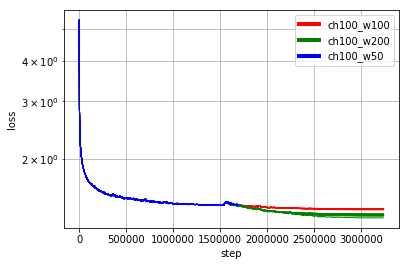

In [6]:
main(
    groups_of_file_names,
    ['red', 'green', 'blue'],
    1,
    'step',
    'loss',
    'linear',
    'log',
    'best',
    900,
    None,
    True
)